# Linguistic gender biases in Wikipedia

## Table of contents

1. [Introduction](#Introduction)
2. [Data preprocesing and extraction](#Data-preprocessing-and-extraction)
3. [Imports](#Imports) 
    1. [Libraries](#Libraries)
    2. [Dictionaries](#Dictionaries)
4. [Gender exploration](#Gender-exploration)
5. [Data exploration](#Data-exploration)
    1. [Gender distribution](#Gender-distribution)
    2. [Occupation distribution](#Occupation-distribution)
    3. [Gender by occupation](#Gender-by-occupation)
    4. [Distribution of the overview's length](#Distribution-of-the-overview's-length)
    5. [Distribution of the percentage of adjectives in an overview](#Distribution-of-the-percentage-of-adjectives-in-an-overview)
    6. [Number of adjectives in an overview](#Number-of-adjectives-in-an-overview)
7. [Adjectives analysis](#Adjectives-analysis)
    1. [Associate subjectivity level and strength to each adjective](#Associate-subjectivity-level-and-strength-to-each-adjective)
    2. [Word cloud for the most common adjectives](#Word-cloud-for-the-most-common-adjectives)
    3. [Usage of strongly subjective adjectives depending on the gender](#Usage-of-strongly-subjective-adjectives-depending-on-the-gender)
8. [Model](#Model)
    1. [Model using adjectives](#Model-using-adjectives)
        1. [Get data](#Get-data)
        2. [Logistic Regression](#Logistic-Regression)
        3. [Estimation of the generalization error](#Estimation-of-the-generalization-error)
    2. [Exploring adjectives representation](#Exploring-adjectives-representation)
        1. [Adjectives appearance in the biographies by gender](#Adjectives-appearance-in-the-biographies-by-gender)
        2. [Joint appearance of adjectives](#Joint-appearance-of-adjectives)
    3. [Linguistic bias per field of occupation](#Linguistic-bias-per-field-of-occupation)
    4. [Model using nouns and adjectives](#Model-using-nouns-and-adjectives)
        1. [Get data](#getdata2)
        2. [Logistic Regression](#lr2)
        3. [Estimation of the generalization error](#error2)
    5. [Exploring nouns and adjectives representation](#Exploring-nouns-and-adjectives-representation)
        1. [Nouns and adjectives appearance in the biographies by gender](#Nouns-and-adjectives-appearance-in-the-biographies-by-gender)
        2. [Joint appearance of nouns and adjectives](#Joint-appearance-of-nouns-and-adjectives)
    6. [Analyzing the results using the Empath library](#Analyzing-the-results-using-the-Empath-library)
9. [Future work](#Future-work)

## Introduction

Wikipedia has become a very large source of information. By November 2019, the number of entries in the English Wikipedia was above 5M [[1]](https://en.wikipedia.org/wiki/Wikipedia:Statistics#Page_views) and it was increasing everyday at a rate of 500 entries in averge. 

In previous studies Wagner et al [[2]](https://arxiv.org/abs/1501.06307) showed how gender biases manifest in Wikipedia in the way women and men are portrayed. In a different study, Graells-Garrido et al [[3]](https://labtomarket.files.wordpress.com/2018/01/wiki_gender_bias.pdf) showed that women biographies are more likely to contain sex-related content. Along with these studies, several others have studied topic-related biases in the way women are portrayed but we can also take a look from the linguistic perspective. 

Linguistic biases is defined as a systematic asymmetry in word choice that reflects the social-category cognitions that are applied to the described group or individual(s) [[4]](https://oxfordre.com/communication/communication/view/10.1093/acrefore/9780190228613.001.0001/acrefore-9780190228613-e-439). We want to analyze how men and women are protrayed and more specifically, the adjectives used to describe them with the aim to spot possible biases from a linguistic perspective. To do so, we will use the overview of the biographies in the English Wikipedia together with other characteristics of the people we are analysing.

Initially we will start by exploring the dataset, i.e. ratio of male and female entries, presence of other genders, etc. Later, we will explore the language used on the overviews by focusing on the adjectives. We restrict the analysis to adjectives given the level of abstraction they provide [[5]](https://www.aaai.org/ocs/index.php/ICWSM/ICWSM15/paper/download/10539/10513). Also, adjectives introduce subjectivity to the descriptions. This analysis will be conducted by first extracting the most frequent adjectives from all the biographies used. With them we will build a vocabulary and use it to create a representation of each person based on the adjectives from our vocabulary that appear in its biography. Later on, we will add the nouns to the model to search for another kind of bias, related to the topics that are reflected in the overviews.

Once we have a vectorial representation of each person, we will create a model using logistic regression that will try to predict if a biography belongs to a male or a female. If this task becomes feasible, it means there is a pattern in the usage of language that allows us to make a distinction between genders, highlighting the presence of a bias. Will our model succeed in its tasks? Continue with us to discover our results! 

[[1] Wikipedia Statistics](https://en.wikipedia.org/wiki/Wikipedia:Statistics#Page_views)

[[2] It's a Man's Wikipedia? Assessing Gender Inequality in an Online Encyclopedia](https://arxiv.org/abs/1501.06307)

[[3] First Women, Second Sex: Gender Bias in Wikipedia](https://labtomarket.files.wordpress.com/2018/01/wiki_gender_bias.pdf)

[[4] Oxford Research Encyclopedia](https://oxfordre.com/communication/communication/view/10.1093/acrefore/9780190228613.001.0001/acrefore-9780190228613-e-439)

[[5] Linguistic Bias in Collaboratively Produced Biographies: Crowdsourcing Social Stereotypes?](https://www.aaai.org/ocs/index.php/ICWSM/ICWSM15/paper/download/10539/10513)

## Data preprocessing and extraction

As stated before, we are only interested in analysing the biographies of the English Wikipedia, so we need to filter them. More precisely, we will use the overviews. In order to do that, we followed these steps:

1. We use the [Wikidata Human Gender Indicators (WHGI)](#http://whgi.wmflabs.org) dataset, which contains all the biography articles in all Wikipedias and it is updated weekly. We use this dataset because it is more updated than the Wikidata one in cluster (dated from 2017). From this dataset (version from November the 4th, 2019 version), we get all the biographies that are in the English Wikipedia and that have a gender. For each entry, we get the Q-id (unique identifier in Wikidata), gender and occupation. Code in [here](createDataset/1_extract_qid_wikidata.py).


2. Then, we need to link the previous information with the Wikipedia article. For that, we use the Wikidata dataset found in the cluster. First, we filter the entries that we obtained in the previous step and obtain the name of the entry in the English Wikipedia. Code in [here](createDataset/2_extract_people_wikidata.py).


3. Next, we have to obtain the biographies from Wikipedia dataset. To do that, we simply join the English Wikipedia dataset (also found in the cluster) with the one obtained in the previous step by the Wikipedia title, which is unique. Code in [here](createDataset/3_filter_people_enwiki.py).


4. Following, we need to extract and clear the overview of the wikipedia text. First, we find the end of the overview (which usually starts either with `==` or `[[Category:` ). Then we clear the references, comments from the editors, quotes and text inside curly brackets. Code in [here](createDataset/4_extract_overview_enwiki.py).


5. Finally, as it will be shown later in the analysis, we filter the database according to gender of the people. We keep only the male and the female as the other genders represent less than 1% of the whole dataset. Code in [here](createDataset/5_filter_female_male.py). 

The final dataset contains 1,383,430 entries and it has the following schema:
```
root
 |-- gender: string (nullable = true)
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- wiki-title: string (nullable = true)
```

The **gender** is represented by the its Wikidata code, the **ID** is the unique code from Wikidata, the **name** is the name of the person (not necessarily unique), the **occupation** is a list of codes from Wikidata corresponding to the occupations of one person, the **overview** is the clean introduction of Wikipedia and the **wiki-title** is the unique name from the English Wikipedia.

In the following steps, we obtain the adjectives and nouns from the overviews and filter the adjectives according to the subjectivity lexicon version used in "Theresa Wilson, Janyce Wiebe, and Paul Hoffmann (2005). Recognizing Contextual Polarity in Phrase-Level Sentiment Analysis. Proc. of HLT-EMNLP-2005." [[6]](https://mpqa.cs.pitt.edu/lexicons/subj_lexicon/). Then we filter the entries that do not have any adjective from the lexicon since no bias could be detected. For the nouns, we change the ones that contain the gender in the word itself (e.g. man/woman, actor/actres, etc.).

## Imports 

### Libraries

In [1]:
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import udf
from pyspark.ml.feature import Tokenizer, RegexTokenizer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score

import os
import json
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from read_json import *
from df_utils import *
from print_utils import *
from model_utils import *
from word_cloud import *

# set random seed
np.random.seed(8)

# set font size for plots
matplotlib.rcParams.update({'font.size': 11})

import warnings
warnings.filterwarnings('ignore')

LOCAL_PATH = "../data/"
N_ITERATIONS = 50

### Dictionaries

In this section, we load the dictionaries used to tranform the codes in the dataset to the corresponding name (dict_genders and dict_occupations). We also load a dictionary to group the occupations by field and the subjectivity lexicon used to analyze the adjectives.

In [2]:
GENDER_DICTIONARY = LOCAL_PATH + "dict_genders.json"
OCCUPATIONS_DICTIONARY = LOCAL_PATH + "dict_occupations.json"
OCCUPATIONS_CATEGORIES_DICTIONARY = LOCAL_PATH + "dict_categories_occupations.json"
SUBJECTIVITY_LEXICON = LOCAL_PATH + "subjectivity_dictionary.json"

dict_genders = read_dictionary(GENDER_DICTIONARY)
dict_occupations = read_dict_occupations(OCCUPATIONS_DICTIONARY)
dict_cat_occ = read_dictionary(OCCUPATIONS_CATEGORIES_DICTIONARY)
subjectivity_dictionary = read_dict_subjectivity(SUBJECTIVITY_LEXICON)

In [3]:
# Create function to translate a code into a category
def translate(mapping):
    def translate_(col):
        return mapping.get(col, "other")
    return udf(translate_, StringType())

## Gender exploration

In this section, we will analyze all the genders in the dataset. Here, we use the dataset extracted after step 4 from the section [data preprocessing and extraction](#Data-preprocessing-and-extraction).

We find that there are 9 different genders in the dataset. However, we group them in male, female and other (because the non-binary genders have very few entries). Since the "other" genders represent less than 1% of the whole dataset, we decide to drop them and focus our research on male and female genders.

In [4]:
conf = SparkConf().setMaster("local[*]").setAll([
                                   ('spark.executor.memory', '12g'),  # find
                                   ('spark.driver.memory','6g'), # your
                                   ('spark.driver.maxResultSize', '2G') # setup
                                  ])
# create the session
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# create the context
sc = spark.sparkContext

In [5]:
WIKI_DATA_ALL_GENDERS = os.path.join(LOCAL_PATH, "overview_wikipedia.json")

In [6]:
df_all_genders = spark.read.json(WIKI_DATA_ALL_GENDERS)

# explode the gender column (create multiple entries for people with a list of genders)
df_all_genders = df_all_genders.withColumn("gender", split(regexp_replace(regexp_replace\
                    (regexp_replace(regexp_replace(df_all_genders['gender'], '\\[', ''), '\\]',\
                    ''), ' ', ''),"'", ""), ","))

df_all_genders = df_all_genders.withColumn("gender", df_all_genders['gender'][0])
df_all_genders.show(5)

+--------+---------+--------------------+--------------------+--------------------+--------------------+
|  gender|       id|                name|          occupation|            overview|          wiki-title|
+--------+---------+--------------------+--------------------+--------------------+--------------------+
|Q6581097|Q26998233|       A. E. Pickard|                  []|Albert Ernest Pic...|       A. E. Pickard|
|Q6581097| Q4647941|       A. J. Masters|['Q177220', 'Q753...|Arthur John Masar...|       A. J. Masters|
|Q6581097| Q4648064|A. L. A. Himmelwr...|['Q13582652', 'Q8...|Abraham Lincoln A...|A. L. A. Himmelwr...|
|Q6581097| Q4647256|  A. N. Sattampillai|        ['Q1234713']|Arumai Nayakam Sa...|  A. N. Sattampillai|
|Q6581097|   Q84136|         A. Vellayan|          ['Q43845']|A. Vellayan (born...|         A. Vellayan|
+--------+---------+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [7]:
# group by gender and compute count
gender_counts = df_all_genders.groupBy("gender").agg(count("*").alias("count")).sort(desc("count"))
print("In total there are {} different genders".format(gender_counts.count()))

In total there are 9 different genders


In [8]:
# group the other genders
gender_counts = gender_counts.withColumn("gender", translate(dict_genders)("gender"))
gender_counts_grouped = gender_counts.groupBy("gender").agg(sum("count").alias("count")).sort(desc("count"))
gender_counts_grouped.show()

+------+-------+
|gender|  count|
+------+-------+
|  male|1154277|
|female| 229423|
| other|    472|
+------+-------+



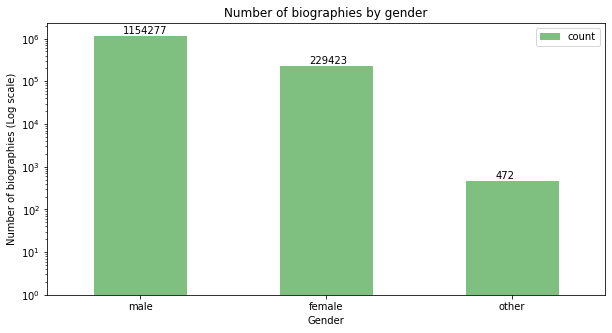

In [9]:
# dataframe to pandas
gender_counts_gourped_pd = gender_counts_grouped.toPandas()

pl = gender_counts_gourped_pd.plot(kind="bar", x="gender", y="count", figsize=(10, 5), log=True, \
                           alpha=0.5, color="green", rot=0)
for p in pl.patches:
    disp= '{:d}'.format(p.get_height())
    pl.annotate(disp, (p.get_x() + 0.16, p.get_height()*1.1))
    
pl.set_xlabel("Gender")
pl.set_ylabel("Number of biographies (Log scale)")
pl.set_title("Number of biographies by gender");

**Attention**: The y-axis is in log-scale!

In [10]:
n_total = gender_counts_gourped_pd['count'].sum()
n_male = gender_counts_gourped_pd[gender_counts_gourped_pd['gender'] == 'male']['count'].values[0]
n_female = gender_counts_gourped_pd[gender_counts_gourped_pd['gender'] == 'female']['count'].values[0]
n_other = n_total - n_male - n_female

print("{:.2f}% of the entries are male".format(n_male/n_total*100))
print("{:.2f}% of the entries are female".format(n_female/n_total*100))
print("{:.2f}% of the entries are other gender".format(n_other/n_total*100))

83.39% of the entries are male
16.57% of the entries are female
0.03% of the entries are other gender


Based on these numbers, we decide to **drop the other genders** and continue our analysis with only female and male.

## Data exploration

In this section, we are going to explore how women are represented in Wikipedia. First, we will start with some basic statistics like the fraction of entries that correspond to each gender and how this varies along different occupations.

After, we will enter in the core analysis of the project by analysing the language used to present the different people. The idea is to focus on the adjectives used in the overviews and look for a bias between male and female representations. The length of the overviews as well as the percentage of adjective in the overviews will be analyzed. 

In [11]:
WIKI_DATA_MALE_FEM = os.path.join(LOCAL_PATH, "wikipedia_male_female.json")
df_male_fem = spark.read.json(WIKI_DATA_MALE_FEM)

In [12]:
# Translate gender and occupations codes into corresponding labels
df_male_fem = df_male_fem.withColumn('gender', translate(dict_genders)('gender'))
df_male_fem.show(5)

+------+---------+--------------------+--------------------+--------------------+--------------------+
|gender|       id|                name|          occupation|            overview|          wiki-title|
+------+---------+--------------------+--------------------+--------------------+--------------------+
|  male|Q26998233|       A. E. Pickard|                  []|Albert Ernest Pic...|       A. E. Pickard|
|  male| Q4647941|       A. J. Masters|['Q177220', 'Q753...|Arthur John Masar...|       A. J. Masters|
|  male| Q4648064|A. L. A. Himmelwr...|['Q13582652', 'Q8...|Abraham Lincoln A...|A. L. A. Himmelwr...|
|  male| Q4647256|  A. N. Sattampillai|        ['Q1234713']|Arumai Nayakam Sa...|  A. N. Sattampillai|
|  male|   Q84136|         A. Vellayan|          ['Q43845']|A. Vellayan (born...|         A. Vellayan|
+------+---------+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



### Gender distribution

We explore again the gender distribution, once we have dropped the other genders and we see that the dataset is very unbalanced, i.e. more than 80% of the entries are male.

In [13]:
# Query to know how many males and females are in the data frame
query = """
SELECT gender, count(DISTINCT id) as count
FROM df_male_fem GROUP BY gender ORDER BY count DESC
"""

gender_counts_pd = spark_sql_pd(df_male_fem, "df_male_fem", query, spark)

83.42% of the entries are male
16.58% of the entries are female


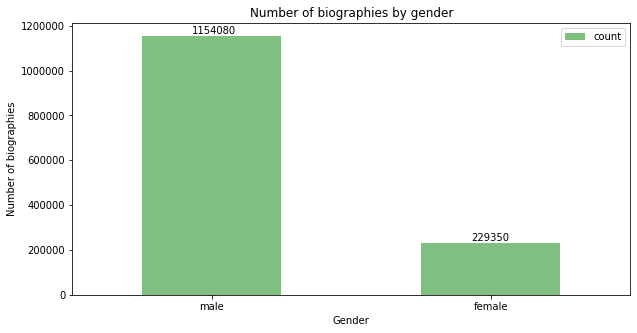

In [14]:
n_total = gender_counts_pd['count'].sum()
n_male = gender_counts_pd[gender_counts_pd['gender'] == 'male']['count'].values[0]
n_female = n_total - n_male

print("{:.2f}% of the entries are male".format(n_male/n_total*100))
print("{:.2f}% of the entries are female".format(n_female/n_total*100))

pl = gender_counts_pd.plot(kind="bar", x="gender", y="count", figsize=(10, 5), log=False, \
                        alpha=0.5, color="green", rot=0)
for p in pl.patches:
    disp= '{:d}'.format(p.get_height())
    pl.annotate(disp, (p.get_x()+0.18, p.get_height()+ 9999))

pl.set_xlabel("Gender")
pl.set_ylabel("Number of biographies")
pl.set_title("Number of biographies by gender");

### Occupation distribution

We explore the most common occupations among biographies. Since there are many different occupations (i.e. 5891), we group them into different fields. We only keep the first 100 most common occupations, which represent almost 80% of the total number of biographies. As a result, we find that the most common field of occupation is **Sports**.

In [15]:
df_occupation_exploded = df_male_fem.withColumn('occupation', explode(split(regexp_replace\
        (regexp_replace(regexp_replace(regexp_replace(df_male_fem['occupation'], '\\[', ''), '\\]',\
        ''), ' ', ''),"'", ""), ","))).filter(col('occupation') != '')

In [16]:
query = """
SELECT occupation, count(DISTINCT id) as count
FROM df_occupation_exploded GROUP BY occupation ORDER BY count DESC
"""

occu_counts = spark_sql(df_occupation_exploded, "df_occupation_exploded", query, spark)
occu_counts_pd = occu_counts.toPandas()

print("In total there are {} different occupations".format(len(occu_counts_pd)))

In total there are 5891 different occupations


**How do we deal with them?**

In [17]:
n_total = occu_counts_pd['count'].sum()
n_first_100 = occu_counts_pd.iloc[:100]['count'].sum()

print("The 100 most common occupations represent {:.2f}% of the all the biographies".format(n_first_100/n_total*100))

The 100 most common occupations represent 78.58% of the all the biographies


In [18]:
n_101 = occu_counts_pd.iloc[101]['count'].sum()

print("The 101th most common occupation represent {:.2f}% of the all the biographies".format(n_101/n_total*100))

The 101th most common occupation represent 0.16% of the all the biographies


Therefore, we decide to **keep only the first 100 occupations**. The other occupations represent less than 1% of the biographies, so we think they are not worth it to be analyzed in detail.

For the first 100 occupations, we will group them in more general fields (e.g. singer and actor will be grouped into the same category named artist).

In [19]:
df_field = df_occupation_exploded.withColumn('occupation', translate(dict_occupations)('occupation'))\
            .withColumn('field', translate(dict_cat_occ)('occupation'))

In [20]:
query = """
SELECT field, count(DISTINCT id) as count
FROM df_field WHERE field != "other"
GROUP BY field ORDER BY count DESC
"""

field_counts_pd = spark_sql_pd(df_field, "df_field", query, spark)

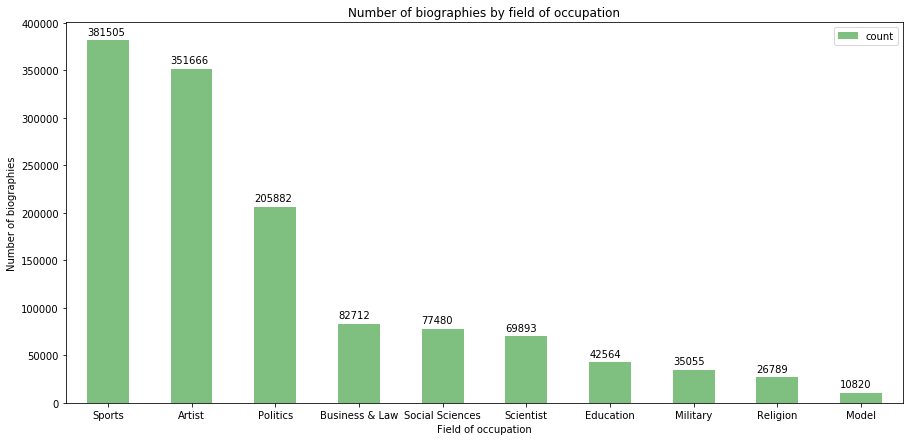

In [21]:
pl = field_counts_pd.plot(kind="bar", x="field", y="count", figsize=(15, 7), log=False, \
                          alpha=0.5, color="green", rot=0)
for p in pl.patches:
    disp= '{:d}'.format(p.get_height())
    pl.annotate(disp, (p.get_x(), p.get_height()+ 6000))
    
pl.set_xlabel("Field of occupation")
pl.set_ylabel("Number of biographies")
pl.set_title("Number of biographies by field of occupation");

The most common field of occupation among people in Wikipedia is **Sports** followed by **Artist** and **Politics**. 

In [22]:
n_total = field_counts_pd['count'].sum()
n_sports = field_counts_pd[field_counts_pd['field'] == 'Sports']['count'].values[0]
n_artist = field_counts_pd[field_counts_pd['field'] == 'Artist']['count'].values[0]
n_politics = field_counts_pd[field_counts_pd['field'] == 'Politics']['count'].values[0]

print("{:.2f}% of the entries work in the sports field".format(n_sports/n_total*100))
print("{:.2f}% of the entries work in the artistic field".format(n_artist/n_total*100))
print("{:.2f}% of the entries work in the politics field".format(n_politics/n_total*100))

29.70% of the entries work in the sports field
27.38% of the entries work in the artistic field
16.03% of the entries work in the politics field


### Gender by occupation

How are the distinct genders represented within the different occupational groups? In general, we can see that the data is very unbalanced in terms of gender. Among the 10 different field of occupation that we have, only for **Model** there is a greater representation of women than men.

In [23]:
query = """
SELECT field, gender, count(DISTINCT id) as count
FROM df_field WHERE field != "other"
GROUP BY field, gender ORDER BY field, gender
"""

occu_gender_counts_pd = spark_sql_pd(df_field, "df_field", query, spark)

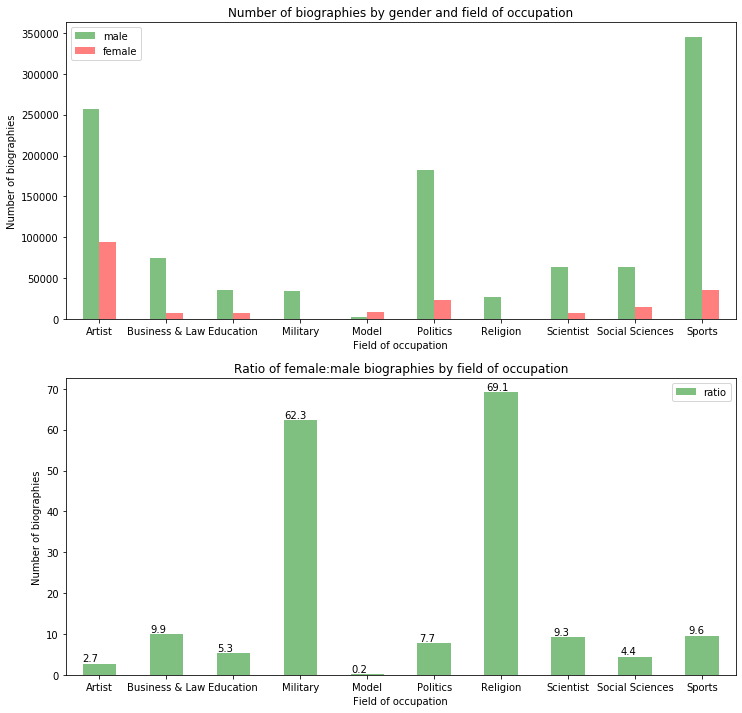

In [24]:
# plot for occupations by gender

male_count = occu_gender_counts_pd[occu_gender_counts_pd['gender'] == 'male']['count'].tolist()
female_count = occu_gender_counts_pd[occu_gender_counts_pd['gender'] == 'female']['count'].tolist()
index = occu_gender_counts_pd['field'].unique().tolist()
occ_by_gender = pd.DataFrame({'male': male_count, 'female': female_count}, index=index)

fig, ax = plt.subplots(2, 1, figsize=(12, 12))
pl = occ_by_gender.plot(kind="bar", log=False, alpha=0.5, color=["green", "red"], rot=0, ax=ax[0])
pl.set_xlabel("Field of occupation")
pl.set_ylabel("Number of biographies")
pl.set_title("Number of biographies by gender and field of occupation");
             
occ_by_gender['ratio'] = occ_by_gender.apply(lambda x: x.male / x.female, axis=1)

pl = occ_by_gender.plot(kind="bar", y='ratio', alpha=0.5, color='green', rot=0, ax=ax[1])
for p in ax[1].patches:
    disp= '{:.1f}'.format(p.get_height())
    ax[1].annotate(disp, (p.get_x() * 1.005, p.get_height() +0.5))
pl.set_xlabel("Field of occupation")
pl.set_ylabel("Number of biographies")
pl.set_title("Ratio of female:male biographies by field of occupation");

From the plot we can point out different details: 
- Female biographies are less in all fields except **Model** which is associated to the mode industry. In this case, for each 5 biographies related to female characters we have one male biography.
- **Religion** and **Military** are the groups where the ratio female:male becomes larger. In religion related biographies for each female we will find 69 males. In military related ones, for each female we will find 62 males.
- The most balanced occupational field is **Artist** where the ratio female:male is of 1:3.

### Distribution of the overview's length 
There are very different biographies in the dataset, some correspond to Artists, some other to Politicians. The overview's length differs significantly from biography to biography. The largest overview's length is of 23,728 words (without punctuation). The overview's length distribution seems to be a power law distribution with a higher mean than median. On average, the distribution of the length of the overviews for women and mean seems to be very similar.

In [25]:
# Remove puncutation from the feature overview
df_overview_len = df_male_fem.withColumn('overview', regexp_replace(regexp_replace(df_male_fem['overview'],\
                                                            r'[^\w\s]',''),'\s\s+', ' '))

# Tokenize feature overview
tokenizer = Tokenizer(inputCol="overview", outputCol="overview_tokens")
df_overview_len = tokenizer.transform(df_overview_len)

# Compute length (number of words) of an overview
tokens_len = udf(lambda s: len(s), IntegerType())
df_overview_len = df_overview_len.withColumn('overview_len', tokens_len(df_overview_len['overview']))

In [26]:
# Query to convert a spark data frame into a pandas data frame, 
# the data frame contains the variables id and overview_len
query = """
SELECT DISTINCT id, overview_len
FROM df_overview_len WHERE overview_len>0
ORDER BY overview_len
"""

overview_len_pd = spark_sql_pd(df_overview_len, "df_overview_len", query, spark)

The distribution's minimum is 1.00
The distribution's maximum is 23728.00
The distribution's mean    is 472.99
The distribution's median  is 291.00


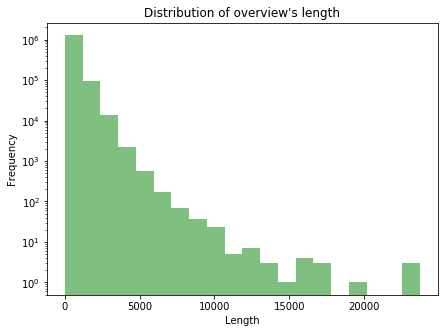

In [27]:
print_overview_len(overview_len_pd) # basic statistics
plot_overview_len(overview_len_pd) # distribution of overview's length

In [28]:
df_overview_len_pd = df_overview_len.select("gender", "id", "overview_len").toPandas()

In [29]:
print("Mean length of male's overviews: {:.3f}".format(np.mean(df_overview_len_pd[\
                                df_overview_len_pd['gender']=='male']['overview_len'])))
print("Mean length of female's overviews: {:.3f}".format(np.mean(df_overview_len_pd[\
                                df_overview_len_pd['gender']=='female']['overview_len'])))

print("\nMedian length of male's overviews: {}".format(np.median(df_overview_len_pd[\
                                df_overview_len_pd['gender']=='male']['overview_len'])))
print("Median length of female's overviews: {}".format(np.median(df_overview_len_pd[\
                                df_overview_len_pd['gender']=='female']['overview_len'])))

Mean length of male's overviews: 477.816
Mean length of female's overviews: 448.658

Median length of male's overviews: 290.0
Median length of female's overviews: 293.0


We can see that there is no significant difference in the length of the overviews for men and women.

### Distribution of the percentage of adjectives in an overview
The distributions of percentage of adjectives in an overview for men and women can be observed below. We can see that they are very similar.

In [30]:
# Load data frames that include adjectives in each overview
WIKI_DATA_NLP_MALE = os.path.join(LOCAL_PATH, "wikipedia_male_nouns_adjectives.json")
WIKI_DATA_NLP_FEM = os.path.join(LOCAL_PATH, "wikipedia_female_nouns_adjectives.json")

df_nlp_male = spark.read.json(WIKI_DATA_NLP_MALE)
df_nlp_fem = spark.read.json(WIKI_DATA_NLP_FEM)

df_adj_stats_male = adj_stats_df(df_nlp_male)
df_adj_stats_fem = adj_stats_df(df_nlp_fem)

ratio_adj_overview_male_pd = ratio_adj_overview(df_adj_stats_male, spark)
ratio_adj_overview_fem_pd = ratio_adj_overview(df_adj_stats_fem, spark)

Overall, each overview does not present a large percentage of adjectives.

DISTRIBUTION FOR FEMALE OVERVIEWS:
The distribution's minimum is 0.02%
The distribution's maximum is 4.35%
The distribution's mean    is 0.34%
The distribution's median  is 0.28%

DISTRIBUTION FOR MALE OVERVIEWS:
The distribution's minimum is 0.00%
The distribution's maximum is 4.76%
The distribution's mean    is 0.34%
The distribution's median  is 0.28%



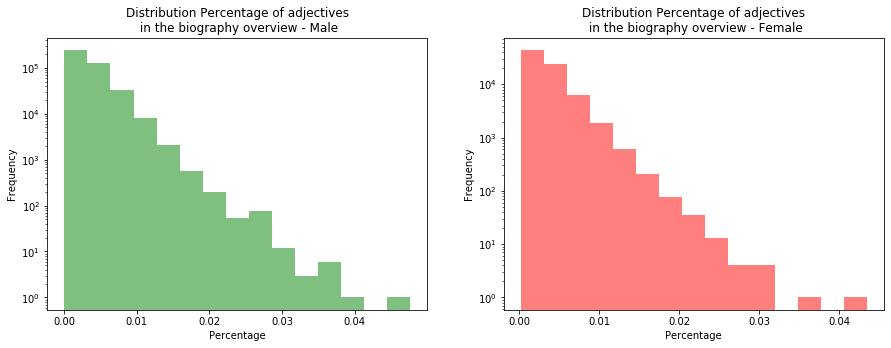

In [31]:
# Print basic statistics
print_overview_statistics(ratio_adj_overview_fem_pd, "FEMALE")
print_overview_statistics(ratio_adj_overview_male_pd, "MALE")

# Plot the histogram of the feature
plot_overview_distribution(ratio_adj_overview_male_pd, ratio_adj_overview_fem_pd)

### Number of adjectives in an overview

Once we know the percentage of adjectives per overview, we analyze the number of adjectives that it represents. We find that the number of adjectives is greater for men than women, but the difference is small.

In [32]:
udf_get_nb_adjs = udf(get_nb_adjs)

df_adj_stats_male = df_adj_stats_male.withColumn("nb-adjs", udf_get_nb_adjs("adjectives"))
df_adj_stats_fem = df_adj_stats_fem.withColumn("nb-adjs", udf_get_nb_adjs("adjectives"))

# compute statistics
stats_nb_adj(df_adj_stats_male, 'Male')
stats_nb_adj(df_adj_stats_fem, 'Female')

Male	| Average num of adjectives: 2.11 | Std of the num of adjectives: 1.96
Female	| Average num of adjectives: 1.92 | Std of the num of adjectives: 1.66


## Adjectives analysis

In this section we analyze the adjectives used to describe the different characters. We use the subjectivity lexicon version used in "Theresa Wilson, Janyce Wiebe, and Paul Hoffmann (2005). Recognizing Contextual Polarity in Phrase-Level Sentiment Analysis. Proc. of HLT-EMNLP-2005." [[6]](https://mpqa.cs.pitt.edu/lexicons/subj_lexicon/). This allows to determine the degree of subjectivity of the vocabulary and if the given adjectives are usually employed with a positive or negative connotation. 

First, we will start by associating each adjective with its subjectivity and strength values. We will then visualize the most common adjectives by gender and their associated degree of strength (negative, positive or neutral). Finally, we will study the usage of strongly subjective adjectives based on the gender. 

### Associate subjectivity level and strength to each adjective

We compare the most common adjectives used for female and male biographies and their subjectivity and strength associated.

In [33]:
# most common adjectives used in male and female overviews
ADJ_MALE = os.path.join(LOCAL_PATH, "count_male_adjectives.json")
ADJ_FEM = os.path.join(LOCAL_PATH, "count_female_adjectives.json")

df_adj_male = spark.read.json(ADJ_MALE)
df_adj_fem = spark.read.json(ADJ_FEM)

In [34]:
# most frequent adjectives for each gender
most_common_adj_male = df_adj_male.orderBy(desc("count"))
most_common_adj_fem = df_adj_fem.orderBy(desc("count"))

In [35]:
# obtain subjectivity degree and strength of the word
def get_subjectivity(adj):
    return subjectivity_dictionary.get(adj)[1]

def get_strength(adj):
    return subjectivity_dictionary.get(adj)[0]

udf_get_subj = udf(get_subjectivity)
udf_get_strength = udf(get_strength)

most_common_adj_male = most_common_adj_male.withColumn("subjectivity", udf_get_subj("adjectives"))
most_common_adj_fem = most_common_adj_fem.withColumn("subjectivity", udf_get_subj("adjectives"))
most_common_adj_male = most_common_adj_male.withColumn("strength", udf_get_strength("adjectives"))
most_common_adj_fem = most_common_adj_fem.withColumn("strength", udf_get_strength("adjectives"))

In [36]:
# show most common adjectives in each case with their subjectivity and strength
print('\t\t MALE')
most_common_adj_male.show(5)
print('\n\t\t FEMALE')
most_common_adj_fem.show(5)

		 MALE
+----------+-----+------------+----------+
|adjectives|count|subjectivity|  strength|
+----------+-----+------------+----------+
|    active|23941|    positive|  weaksubj|
|     major|23875|     neutral|  weaksubj|
|      best|23299|    positive|strongsubj|
|      high|20767|     neutral|  weaksubj|
|    famous|16819|    positive|  weaksubj|
+----------+-----+------------+----------+
only showing top 5 rows


		 FEMALE
+----------+-----+------------+----------+
|adjectives|count|subjectivity|  strength|
+----------+-----+------------+----------+
|      best| 6471|    positive|strongsubj|
|      high| 4162|     neutral|  weaksubj|
|    active| 4089|    positive|  weaksubj|
|   popular| 3983|    positive|  weaksubj|
|      long| 3856|    negative|strongsubj|
+----------+-----+------------+----------+
only showing top 5 rows



Up to now we have obtained the most used adjectives for each gender and associate them with their degree of strength and subjectivity. If we compare the top-five adjectives of each gender, we can see there are 3 shared words: **active**, **best** and **high**. 

### Word cloud for the most common adjectives

Visualization of the most common adjectives used in the overviews.

In [37]:
adj_male_dict = most_common_adj_male.select('adjectives', 'count').toPandas().set_index('adjectives').T.to_dict('records')
adj_female_dict = most_common_adj_fem.select('adjectives', 'count').toPandas().set_index('adjectives').T.to_dict('records')

The following word cloud shows the 500 most common adjectives used in male and female biographies. The size of the word is proportional to the frequency of appearance while the color represents the connotation. In <span style="color:#377eb8">**blue**</span>  we see the adjectives ranked as positive, in <span style="color:#ff7f00">**orange**</span>  the ones ranked negative and in <span style="color:#999999">**grey**</span> the ones considered as neutral. 

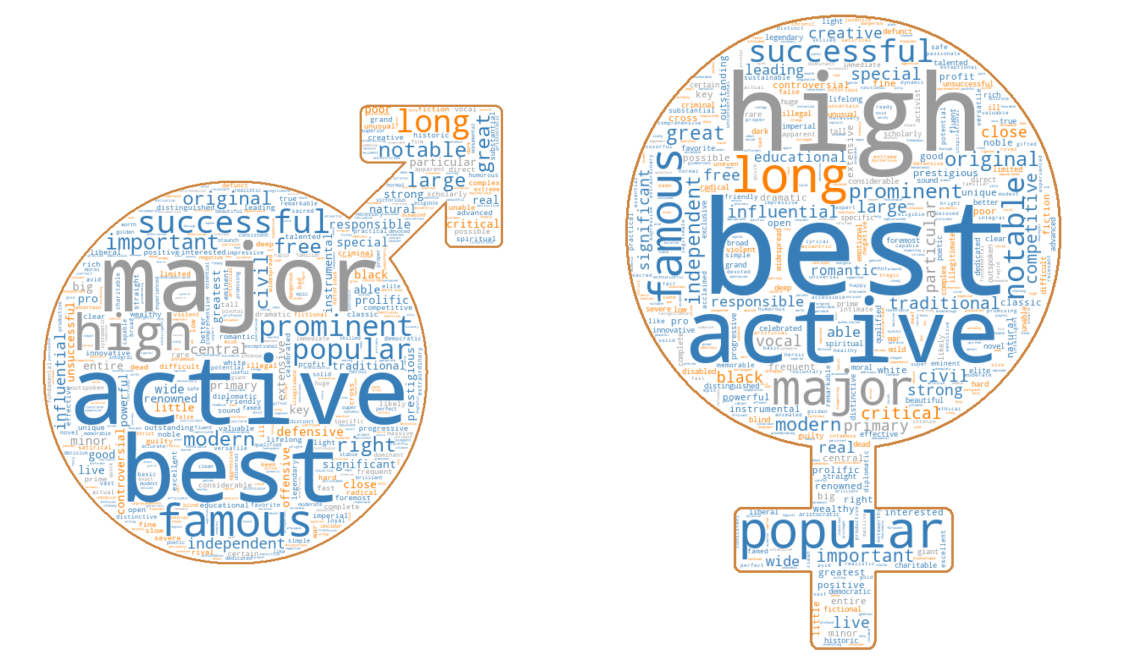

In [38]:
word_to_color_dict = word_to_color(subjectivity_dictionary)

wc_male   = generate_wordcloud("../data/male.png", adj_male_dict, word_to_color_dict)
wc_female = generate_wordcloud("../data/female.png", adj_female_dict, word_to_color_dict)

viz_wordcloud(wc_male, wc_female)

For both genders we see a higher presence of positive-related words as well as some shared adjectives as we showed in the previous subsection. Given the results of this first inspection, we will conduct further quantitative research to see the usage of positive versus negative connoted words and their degree of subjectivity.

### Usage of strongly subjective adjectives depending on the gender

Most of the adjectives used in the overviews have a weak subjectivity. How are the ones with a strong subjectivity distributed?

In [39]:
# compute statistics for each gender
ov_subj_male, strength_adj_male = subjectivity_strength(most_common_adj_male)
ov_subj_female, strength_adj_female = subjectivity_strength(most_common_adj_fem)

# show results in a single table
ov_subj_genders = ov_subj_male.withColumnRenamed('sum_', 'male_sum').\
join(ov_subj_female.withColumnRenamed('sum_', 'female_sum'), ['strength', 'subjectivity'])

strength_genders = strength_adj_male.withColumnRenamed('percentage', 'male_percentage').\
join(strength_adj_female.withColumnRenamed('percentage', 'female_percentage'), ['strength', 'subjectivity']).\
drop('sum(count)')

# visualize
ov_subj_genders_pd = ov_subj_genders.toPandas()
strength_genders_pd = strength_genders.toPandas().round(2)

In [40]:
percentage_subj = 100*ov_subj_genders_pd.groupby('subjectivity').sum()/\
                            ov_subj_genders_pd[['female_sum','male_sum']].sum()
percentage_subj.round(2).rename(columns={'female_sum':'percentage_female', 'male_sum':'percentage_male'})

,percentage_female,percentage_male
subjectivity,,
both,0.00,0.00
negative,20.17,20.74
neutral,15.40,16.21
positive,64.43,63.06


In [41]:
percentage_strength = 100*ov_subj_genders_pd.groupby('strength').sum()/\
                            ov_subj_genders_pd[['female_sum','male_sum']].sum()
percentage_strength.round(2).rename(columns={'female_sum':'percentage_female', 'male_sum':'percentage_male'})

,percentage_female,percentage_male
strength,,
strongsubj,30.4,28.08
weaksubj,69.6,71.92


In [42]:
strength_genders_pd

,strength,subjectivity,male_percentage,female_percentage
0,strongsubj,negative,8.74,9.38
1,strongsubj,positive,18.28,19.82


After analysing the distribution of adjectives along the overviews, we can see the distribution of strengths and subjectivities is similar for both genders. In both cases, the usage of negative words to describe the different characters is lower than the positive ones and the adjectives used are mostly weakly subjective.
In terms of strongly subjective words, again the positive ones are more used than the negatives and they are equally distributed for both genders.
Given the analysis about the adjectives conducted up to now, we are still not able to distinguish if there exist a clear linguistic bias in the usage of the words. Nevertheless, the following section will introduce new insights to the discussion.

## Model

### Model using adjectives

In this section, we build a model with the most common adjectives in the overviews of the biographies to find out if there is any bias on how males and females are described. We force to have a balanced dataset and our hypothesis is that if the accuracy obtained is higher than 0.5 there is a bias, because the model is able to learn something from the features. Therefore, if that is the case, we will analyze which adjectives create that bias from the coefficients of the model.

Since the whole dataset is very unbalanced, we take the 100 most common adjectives from male and the 100 most common adjectives from female biographies, and we merge them. That gives us a total of **114 adjectives** to use as features (Bag of Words) of our model. To encode these features, we create a vector of features with 1 if the adjective is present in the overview and 0 if not. The output we want to predict corresponds to the gender of the biographies. We use 0 for male and 1 for female. 

In order to make sure that the model is not learning from other features, we need to properly balance the data. For that, we use **propensity score matching**. We are going to use one single feature which is the occupation. Therefore, we are going to select the same number of female and male for each occupation, i.e. for each occupation we check which is the minority in terms of gender and for each sample of that gender, we randomly take another sample of the other gender.

We train a **logistic regression** model and obtain an **accuracy of 54.6%** for the test dataset, which means that **the bias exists**. In order to know which adjectives influence more on the linguistic bias, we analyze their coefficients. The higher the coefficient, the more biased to female overviews and the lower the coefficient, the more biased to male overviews. Then, we analyze the subjectivity of these adjectives.

In [43]:
# encode input: kind of one-hot coding 🔥
def encode_input(list_words_present, list_adj_to_encode):
    encoding = np.zeros(len(list_adj_to_encode))
    for adj in list_words_present:
        if adj in list_adj_to_encode:
            i = list_adj_to_encode.index(adj)
            encoding[i] = 1
    return encoding

# encode gender
def encode_output(gender):
    return int(gender == 'female')

# apply encoder to df
def encode_df(df, cat, vocabulary):
    df_encoded = df.copy()
    df_encoded['input'] = df_encoded[cat].map(lambda x: encode_input(x, vocabulary))
    df_encoded['output'] = df_encoded.gender.map(lambda x: encode_output(x))
    return df_encoded

In [44]:
def get_input_output_gender(df):
    X = np.stack(df.input)
    y = np.stack(df.output)
    return X,y

def get_input_output(df_fem, df_male):
    X_fem, y_fem = get_input_output_gender(df_fem)
    X_male, y_male = get_input_output_gender(df_male)
    
    X = np.concatenate((X_fem, X_male), axis=0)
    y = np.concatenate((y_fem, y_male), axis=0)
    return X,y

In [45]:
# balancing the data by occupation (propensity score matching)
def get_balanced_data(unique_cat_occ, vocabulary, df_fem_pd, df_male_pd):
    # Initialize train and test data
    X_train = np.empty((0,len(vocabulary)))
    X_test = np.empty((0,len(vocabulary)))

    y_train = np.empty((0))
    y_test = np.empty((0))
    
    for cat in unique_cat_occ:
        n_cat_fem = len(df_fem_pd[df_fem_pd['occupation'] == cat])
        n_cat_male = len(df_male_pd[df_male_pd['occupation'] == cat])
        n_total = np.min((n_cat_fem, n_cat_male))

        # split data in test and train
        n_train = np.round(0.7 * n_total).astype(np.uint)
        n_test = (n_total - n_train).astype(np.uint)
        
        if n_train != 0 and n_test != 0:
            # select entries for the train and test df
            if n_cat_fem == n_total:
                train_indices_fem = np.random.choice(range(n_cat_fem), n_train, replace=False)
                test_indices_fem = np.setdiff1d(range(n_cat_fem), train_indices_fem)

                train_indices_male = np.random.choice(range(n_cat_male), n_train, replace=False)
                left_indices_male = np.setdiff1d(range(n_cat_male), train_indices_male)
                test_indices_male = np.random.choice(left_indices_male, n_test, replace=False)

            else: 
                train_indices_male = np.random.choice(range(n_cat_male), n_train, replace=False)
                test_indices_male = np.setdiff1d(range(n_cat_male), train_indices_male)

                train_indices_fem = np.random.choice(range(n_cat_fem), n_train, replace=False)
                left_indices_fem = np.setdiff1d(range(n_cat_fem), train_indices_fem)
                test_indices_fem = np.random.choice(left_indices_fem, n_test, replace=False)

            # ensure balanced dataset
            assert len(train_indices_fem) == len(train_indices_male)
            assert len(test_indices_fem) == len(test_indices_male)

            # build train df
            df_fem_cat_train = df_fem_pd[df_fem_pd['occupation']==cat].iloc[train_indices_fem]
            df_male_cat_train = df_male_pd[df_male_pd['occupation']==cat].iloc[train_indices_male]

            # build test df
            df_fem_cat_test = df_fem_pd[df_fem_pd['occupation']==cat].iloc[test_indices_fem]
            df_male_cat_test = df_male_pd[df_male_pd['occupation']==cat].iloc[test_indices_male]

            # get input, output from train data
            X_train_cat, y_train_cat = get_input_output(df_fem_cat_train, df_male_cat_train)
            # get input, output from test data
            X_test_cat, y_test_cat = get_input_output(df_fem_cat_test, df_male_cat_test)

            X_train = np.concatenate((X_train, X_train_cat), axis=0)
            y_train = np.concatenate((y_train, y_train_cat), axis=0)

            X_test = np.concatenate((X_test, X_test_cat), axis=0)
            y_test = np.concatenate((y_test, y_test_cat), axis=0)
    return X_train, y_train, X_test, y_test

#### Get data

We get the balanced data to train the model. We take 70% of the data for training the model and 30% to test it. This gives a total of 131,402 samples for training and 56,296 for testing.

In [46]:
# Get first 100 most occupations
first_100_occu = occu_counts.limit(100).select('occupation')
first_100_occu_pd = first_100_occu.toPandas()
occupation_list = list(first_100_occu_pd['occupation'])

In [47]:
df_model_male = df_nlp_male.withColumn('occupation', explode(split(regexp_replace(regexp_replace(regexp_replace\
        (regexp_replace(df_nlp_male['occupation'], '\\[', ''), '\\]', ''), ' ', ''),"'", ""), ",")))\
       .filter(col('occupation') != '')

df_model_fem = df_nlp_fem.withColumn('occupation', explode(split(regexp_replace(regexp_replace(regexp_replace\
        (regexp_replace(df_nlp_fem['occupation'], '\\[', ''), '\\]', ''), ' ', ''),"'", ""), ",")))\
       .filter(col('occupation') != '')

df_model_male = first_100_occu.join(df_model_male, ['occupation'], how='inner')
df_model_fem = first_100_occu.join(df_model_fem, ['occupation'], how='inner')

df_model_male = df_model_male.withColumn('gender', translate(dict_genders)('gender'))
df_model_fem = df_model_fem.withColumn('gender', translate(dict_genders)('gender'))

In [48]:
df_model_male_pd = df_model_male.select("id", "gender", "occupation", "adjectives", "nouns").toPandas()
df_model_fem_pd = df_model_fem.select("id", "gender", "occupation", "adjectives", "nouns").toPandas()

In [49]:
most_common_adj = vocabulary_common_adj(most_common_adj_fem, most_common_adj_male)

In [50]:
df_model_male_pd = encode_df(df_model_male_pd, cat='adjectives', vocabulary=most_common_adj)
df_model_fem_pd = encode_df(df_model_fem_pd, cat='adjectives', vocabulary=most_common_adj)

In [51]:
X_train, y_train, X_test, y_test = get_balanced_data(occupation_list, most_common_adj, \
                                                     df_model_fem_pd, df_model_male_pd)

In [52]:
print("Total size of vocabulary: {}".format(len(most_common_adj)))

print("\nNumber of entries for each gender on train: {}".format(int(y_train.shape[0]/2)))
print("Number of entries for each gender on test: {}".format(int(y_test.shape[0]/2)))

print("\nShape of train input:\t{}".format(X_train.shape))
print("Shape of train output:\t{}".format(y_train.shape))

print("\nShape of test input:\t{}".format(X_test.shape))
print("Shape of test output:\t{}".format(y_test.shape))

Total size of vocabulary: 114

Number of entries for each gender on train: 65701
Number of entries for each gender on test: 28148

Shape of train input:	(131402, 114)
Shape of train output:	(131402,)

Shape of test input:	(56296, 114)
Shape of test output:	(56296,)


#### Logistic Regression

We build the model with Logistic Regression since it is a **binary classification**. We get an **accuracy of 54.6%**. Since this value is higher than 50%, we can say that the bias in the adjectives used to describe females and males exists. The adjective most correlated to **women** is **beautiful** while for **men** is **offensive**.

In [53]:
# generate model (Logistic Regression)
lr = LogisticRegression()

# train the model
lr.fit(X_train, y_train)

# predict
y_pred = lr.predict(X_test)

In [54]:
print_confusion_matrix(y_test, y_pred) # confusion matrix (true - rows, pred - cols)
print_accuracy_model(lr, X_test, y_test) # accuracy

Confusion Matrix:

T\P 	 male 	 female
male 	 13279 	 14869
female 	 10607 	 17541

T - True, P - Predicted


Accuracy of the model in test dataset: 0.547
AUC ROC of the model in test dataset: 0.573


In [55]:
# Create pandas DataFrame with coefficients and its corresponding adjective
data_pd = {'adjective': most_common_adj, 'coefficient': lr.coef_[0].tolist()}   
df_coef = pd.DataFrame(data_pd) 
df_coef = df_coef.sort_values(by='coefficient', ascending=False).reset_index(drop=True)

In [56]:
# Get subjectivity and strength of the adjectives
df_coef['subjectivity'] = df_coef['adjective'].map(lambda x: get_subjectivity(x))
df_coef['strength'] = df_coef['adjective'].map(lambda x: get_strength(x))

In [57]:
print("Adjectives correlated to female bias:")
df_coef.head(5)

Adjectives correlated to female bias:


,adjective,coefficient,subjectivity,strength
0,beautiful,0.811004,positive,strongsubj
1,profit,0.602940,positive,weaksubj
2,cross,0.571114,negative,strongsubj
3,creative,0.476731,positive,strongsubj
4,romantic,0.429920,positive,strongsubj


In [58]:
print("Adjectives correlated to male bias:")
df_coef.tail(5)

Adjectives correlated to male bias:


,adjective,coefficient,subjectivity,strength
109,diplomatic,-0.521117,positive,weaksubj
110,defensive,-0.573256,negative,weaksubj
111,hard,-0.629722,negative,weaksubj
112,certain,-0.725816,neutral,weaksubj
113,offensive,-0.906791,negative,weaksubj


Since we know there is a bias, we check which adjectives are the most correlated to describe females and males. We can see that the adjectives most correlated with females are **beautiful, profit, cross, creative and romantic**, while the ones most correlated with males are **offensive, certain, hard, defensive and diplomatic**.

As shown in the tables, the adjectives related to men are weakly subjective and most of them have a negative connotation, whereas the ones related to women are mostly strong subjective and have a positive connotation. Therefore, the **overviews portraying females are more likely to contain subjectivity**.

#### Estimation of the generalization error

To verify the robustness of the model, we estimate the generalization error. To do that, we randomly balance the data 50 different times and train 50 different models. Then, we compute the mean and variance of the obtained accuracies. The variance is very low, which means that we obtained strong results and the **model is robust**.

In [59]:
accuracy_list = []
aucroc_list = []

for _ in range(N_ITERATIONS):
    X_train, y_train, X_test, y_test = get_balanced_data(occupation_list, most_common_adj, \
                                                     df_model_fem_pd, df_model_male_pd)
    # generate model
    lr = LogisticRegression()
    # train the model
    lr.fit(X_train, y_train)
    accuracy_list.append(lr.score(X_test, y_test))
    aucroc_list.append(roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]))

In [60]:
print('Accuracy: {:.3} +/- {:.3}'.format(np.mean(accuracy_list), np.std(accuracy_list)))
print('AUC ROC: {:.3} +/- {:.3}'.format(np.mean(aucroc_list), np.std(aucroc_list)))

Accuracy: 0.546 +/- 0.00174
AUC ROC: 0.57 +/- 0.00181


### Exploring adjectives representation

#### Adjectives appearance in the biographies by gender

In order to verify our results, we analyze the frequency of the most predictive adjectives. We can oberserve that indeed the most predictive words for women and for men are more likely to appear in their overviews.

In [61]:
fem_count = len(df_model_fem_pd)
male_count = len(df_model_male_pd)

fem_adj = df_model_fem_pd.explode('adjectives')[['adjectives', 'id']].groupby(['adjectives'], as_index=False).\
            count().rename(columns={'id':'count'})
male_adj = df_model_male_pd.explode('adjectives')[['adjectives', 'id']].groupby(['adjectives'], as_index=False).\
            count().rename(columns={'id':'count'})

adj_presence = fem_adj.merge(male_adj, on='adjectives', suffixes=('_female','_male'))
adj_presence['freq_female'] = 100*adj_presence['count_female']/fem_count
adj_presence['freq_male'] = 100*adj_presence['count_male']/male_count

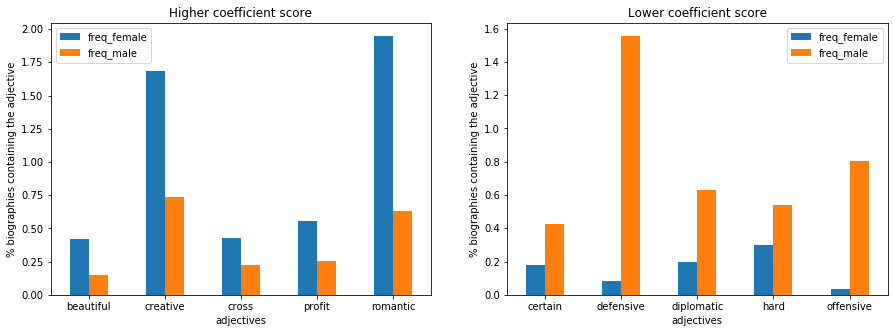

In [62]:
num_adj = 5

f, ax = plt.subplots(1, 2, figsize=(15,5))
adj_presence[adj_presence.adjectives.isin(df_coef.head(num_adj)['adjective'].tolist())][['adjectives', 'freq_female', 'freq_male']].\
plot(kind='bar', x='adjectives', ax=ax[0], rot=0)
adj_presence[adj_presence.adjectives.isin(df_coef.tail(num_adj)['adjective'].tolist())][['adjectives', 'freq_female', 'freq_male']].\
plot(kind='bar', x='adjectives', ax=ax[1], rot=0)

ax[0].set_title('Higher coefficient score')
ax[1].set_title('Lower coefficient score')
ax[0].set_ylabel('% biographies containing the adjective')
ax[1].set_ylabel('% biographies containing the adjective')
plt.show()

#### Joint appearance of adjectives

Now, we compute the correlation between the most predictive adjectives for both genders. We can see that the results are very similar for both genders, there is a low correlation. This means that the coefficients of the model reflect the importance of the model's features, i.e. the adjectives showed in the previous section are the most correlated to female and male overviews.

In [63]:
def similarity_score(df_f, df_m, words, column):
    f_similarity = {}
    m_similarity = {}
    
    #fem_common_adj = df_f.withColumn('adjectives', explode(df_f.adjectives))
    #male_common_adj = df_m.withColumn('adjectives', explode(df_m.adjectives))
    fem_common_adj = df_f.drop_duplicates(subset=['id']).explode(column)[['id', column]]
    male_common_adj = df_m.drop_duplicates(subset=['id']).explode(column)[['id', column]]
    
    for i in range(len(words)): 
        print("\r Processing {} out of {}".format(i+1, len(words)), end="")
        w1 = words[i]
        f_w1 = set(fem_common_adj[fem_common_adj[column] == w1]['id'])
        m_w1 = set(male_common_adj[male_common_adj[column] == w1]['id'])
        
        for j in range(i+1, len(words)):
            w2 = words[j]
            f_w2 = set(fem_common_adj[fem_common_adj[column] == w2]['id'])
            m_w2 = set(male_common_adj[male_common_adj[column] == w2]['id'])
        
            f_similarity[(w1, w2)] = len(f_w1.intersection(f_w2))/len(f_w1.union(f_w2))
            f_similarity[(w2, w1)] = f_similarity[(w1, w2)]
            
            m_similarity[(w1, w2)] = len(m_w1.intersection(m_w2))/len(m_w1.union(m_w2))
            m_similarity[(w2, w1)] = m_similarity[(w1, w2)]
    return f_similarity, m_similarity

In [64]:
num_adj = 5
fem_sim, male_sim = similarity_score(df_model_fem_pd, df_model_male_pd, \
                    df_coef.head(num_adj)['adjective'].tolist() + df_coef.tail(num_adj)['adjective'].tolist(), 'adjectives')

 Processing 10 out of 10

In [65]:
words = df_coef.head(num_adj)['adjective'].tolist() + df_coef.tail(num_adj)['adjective'].tolist()

f_sim = np.zeros((len(words),len(words)))
m_sim = np.zeros((len(words),len(words)))

for i in range(len(words)):
    for j in range(i+1, len(words)):
        f_sim[i,j] = fem_sim[(words[i], words[j])]
        f_sim[j,i] = f_sim[i,j]
        m_sim[i,j] = male_sim[(words[i], words[j])]
        m_sim[j,i] = m_sim[i,j]

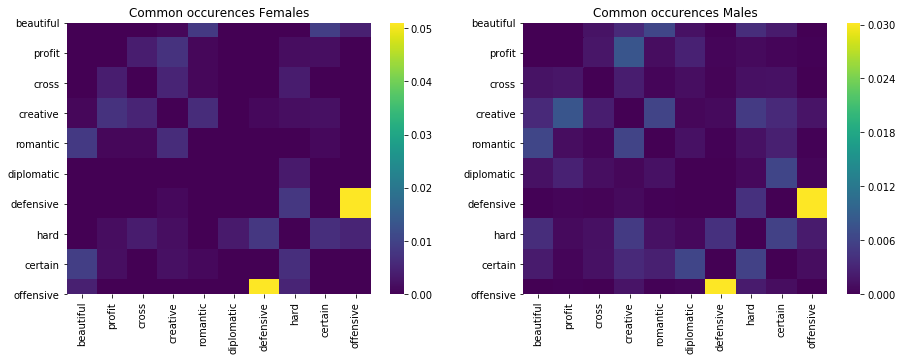

In [66]:
f, ax = plt.subplots(1,2, figsize=(15,5))
sns.heatmap(f_sim, xticklabels=words, yticklabels=words, cmap='viridis', ax=ax[0])
sns.heatmap(m_sim, xticklabels=words, yticklabels=words, cmap='viridis', ax=ax[1])

ax[0].set_title('Common occurences Females')
ax[1].set_title('Common occurences Males')

plt.show()

### Linguistic bias per field of occupation

Once we have explored the general linguistic bias, we explore it for each field of occupation to see if there are some occupations with a higher bias than others. We measure the error by randomly balancing the data and computing the accuracy for each model. The fields of **Military, Model and Religion** are the only ones where we cannot state that there exists a bias, since the accuracy is not always above 50%. These fields are also the ones with fe**WEST** (BOB) data, so this might be the reason behind the high variability of the results. The accuracy for the other fields of occupations is approximately the same, between 55% and 60%. The one with highest bias (i.e. highest accuracy) is **Business and Law**.

In [67]:
def encode_occupation_input(df_field_model, most_common_adj_field):
    # convert both spark data frames previously created to pandas
    df_field_model_pd = df_field_model.toPandas()

    # Kind of one-hot encoding
    df_encoded_adj_field = encode_df(df_field_model_pd, cat='adjectives', vocabulary=most_common_adj_field)
    return df_encoded_adj_field

In [68]:
def train_model_by_occupation(df_encoded_fem, df_encoded_male, most_common_adj, field):

    # Split data into train and test, taking into account the data's balance
    X_train, y_train, X_test, y_test = get_balanced_data(field, most_common_adj, df_encoded_fem, df_encoded_male)
   
    
    # generate model
    lr = LogisticRegression()

    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
        
    # Save accuracy score of the model
    accuracy_score = lr.score(X_test, y_test)
    
    # Save AUC score of the model
    AUC_score = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
    return accuracy_score, AUC_score

In [69]:
unique_cat_occ = np.unique(list(dict_cat_occ.values()))

In [70]:
first_100_occu_pd['field'] = occu_counts_pd['occupation'].apply(lambda x: dict_cat_occ.get(dict_occupations.get(x)))

In [71]:
df_model_fem_pd = df_model_fem_pd.drop(['input', 'output'], axis=1)
df_model_male_pd = df_model_male_pd.drop(['input', 'output'], axis=1)

In [72]:
df_model_fem_pd['field'] = df_model_fem_pd['occupation'].apply(lambda x: dict_cat_occ.get(dict_occupations.get(x)))
df_model_male_pd['field'] = df_model_male_pd['occupation'].apply(lambda x: dict_cat_occ.get(dict_occupations.get(x)))

In [73]:
accuracy_scores_list = []
AUC_scores_list = []

for field in list(unique_cat_occ):
    print("Running model for {}".format(field))
    accu_tmp = []
    AUC_tmp = []
    
    # filter the datasets with the occupation field
    df_fem_field_pd = filter_occupation(df_model_fem_pd, field)
    df_male_field_pd = filter_occupation(df_model_male_pd, field)
        
    vocabulary_adj_field = vocabulary_common_adj_field(df_fem_field_pd, df_male_field_pd, 100)
    df_fem_encoded = encode_df(df_fem_field_pd, cat='adjectives', vocabulary=vocabulary_adj_field)
    df_male_encoded = encode_df(df_male_field_pd, cat='adjectives', vocabulary=vocabulary_adj_field)
    
    # Store in a list a certain field for balancing the data sets
    unique_cat_occ_field = list(first_100_occu_pd[first_100_occu_pd['field'] == field]['occupation'])
        
    for i in range(N_ITERATIONS):
        
        acc_scopes = train_model_by_occupation(df_fem_encoded, df_male_encoded, vocabulary_adj_field,\
                                               unique_cat_occ_field)
        accu_tmp.append(acc_scopes[0])
        AUC_tmp.append(acc_scopes[1])
        
    accuracy_scores_list.append(accu_tmp)
    AUC_scores_list.append(AUC_tmp)

Running model for Artist
Running model for Business & Law
Running model for Education
Running model for Military
Running model for Model
Running model for Politics
Running model for Religion
Running model for Scientist
Running model for Social Sciences
Running model for Sports


In [74]:
bias_occu_accuracy_df = pd.DataFrame(accuracy_scores_list).T
bias_occu_AUC_df = pd.DataFrame(AUC_scores_list).T
bias_occu_accuracy_df.columns = [list(unique_cat_occ)]
bias_occu_AUC_df.columns = [list(unique_cat_occ)]

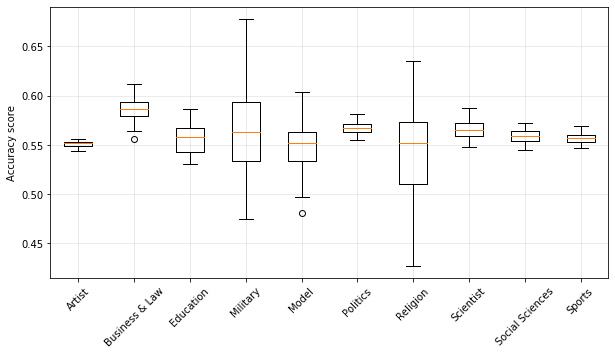

In [75]:
fig, ax = plt.subplots(figsize=(10,5))
pos = np.array(range(bias_occu_accuracy_df.T.shape[0])) + 1
ax.boxplot(bias_occu_accuracy_df.T, positions=pos)
ax.set_xticklabels(unique_cat_occ, rotation = 45)
ax.set_ylabel('Accuracy score')
ax.grid(alpha = 0.3)
plt.show()

In [76]:
bias_occu_accuracy_mean = list(np.mean(bias_occu_accuracy_df))
bias_occu_accuracy_std = list(np.std(bias_occu_accuracy_df))

In [77]:
def print_cv_scores(mean_scores, std_scores, model_names): 
    # Print number of missing values per feature and its corresponding percentage
    dash = '-' * 55
    print(dash)
    print('{:<25s}{:<15s}{:<15s}'.format('Model name','Mean Accuracy', 'Std Accuracy'))
    print(dash)
    for i in range(len(mean_scores)):
        print('{:<25s}{:<15.3f}{:<15.3f}'.format(model_names[i], mean_scores[i], std_scores[i]))
    print(dash)
    
print_cv_scores(bias_occu_accuracy_mean, bias_occu_accuracy_std, list(unique_cat_occ))

-------------------------------------------------------
Model name               Mean Accuracy  Std Accuracy   
-------------------------------------------------------
Artist                   0.551          0.003          
Business & Law           0.586          0.012          
Education                0.556          0.014          
Military                 0.564          0.043          
Model                    0.549          0.025          
Politics                 0.567          0.006          
Religion                 0.538          0.045          
Scientist                0.565          0.009          
Social Sciences          0.559          0.006          
Sports                   0.557          0.005          
-------------------------------------------------------


### Model using nouns and adjectives

Now, in addition to adjectives, we also include nouns to the model. We follow the same procedure as before, but now we take the most common 100 words among nouns and adjectives for females and males and then merge them. We get a total of **132 words**, most of them being nouns. We use once again the propensity score matching by occupation to balance the data. In this case, we obtain an **accuracy of 65.7%**, so the **bias still exists** and it is easier to detect.

#### Get data <a name="getdata2"></a>

In [78]:
# most common nouns used in male and female overviews
NOUN_MALE = os.path.join(LOCAL_PATH, "count_male_nouns.json")
NOUN_FEM = os.path.join(LOCAL_PATH, "count_female_nouns.json")

most_common_noun_male = spark.read.json(NOUN_MALE)
most_common_noun_fem = spark.read.json(NOUN_FEM)

In [79]:
# get most common nouns for male and female
first_100_noun_male = most_n_common(most_common_noun_male, 100)
first_100_noun_fem = most_n_common(most_common_noun_fem, 100)

In [80]:
# get most common adjectives for male and female
first_100_adj_male = most_n_common(most_common_adj_male, 100)
first_100_adj_fem = most_n_common(most_common_adj_fem, 100)

In [81]:
# add a column indicating the category (adjective or noun)
first_100_noun_male['cat'] = 'noun'
first_100_noun_fem['cat'] = 'noun'

first_100_adj_male['cat'] = 'adj'
first_100_adj_fem['cat'] = 'adj'

In [82]:
# select columns and rename them
first_100_adj_fem = first_100_adj_fem[['adjectives', 'count', 'cat']]
first_100_adj_fem = first_100_adj_fem.rename(columns={"adjectives": "word"})

first_100_adj_male = first_100_adj_male[['adjectives', 'count', 'cat']]
first_100_adj_male = first_100_adj_male.rename(columns={"adjectives": "word"})

# rename columns
first_100_noun_fem = first_100_noun_fem.rename(columns={"nouns": "word"})
first_100_noun_male = first_100_noun_male.rename(columns={"nouns": "word"})

In [83]:
first_adj_noun_fem = first_100_adj_fem.append(first_100_noun_fem).sort_values(by=['count'], ascending=False).\
                        reset_index(drop=True).copy().iloc[:100]
first_adj_noun_male = first_100_adj_male.append(first_100_noun_male).sort_values(by=['count'], ascending=False).\
                        reset_index(drop=True).copy().iloc[:100]

In [84]:
n_adj_fem = np.sum(first_adj_noun_fem['cat'] == 'adj')
n_noun_fem = len(first_adj_noun_fem) - n_adj_fem
print("For female, there are {} adjectives and {} nouns".format(n_adj_fem, n_noun_fem))

n_adj_male = np.sum(first_adj_noun_male['cat'] == 'adj')
n_noun_male = len(first_adj_noun_male) - n_adj_male
print("For male, there are {} adjectives and {} nouns".format(n_adj_male, n_noun_male))

For female, there are 5 adjectives and 95 nouns
For male, there are 4 adjectives and 96 nouns


In [85]:
# create vocabulary for the model with the set of adjectives and nouns previous found
most_common_adj_noun = set()
most_common_adj_noun.update(first_adj_noun_fem['word'].tolist())
most_common_adj_noun.update(first_adj_noun_male['word'].tolist())
most_common_adj_noun = list(most_common_adj_noun)

In [86]:
# join nouns and adjectives in a new column called words
df_model_fem_pd['words'] = df_model_fem_pd['adjectives'] + df_model_fem_pd['nouns']
df_model_male_pd['words'] = df_model_male_pd['adjectives'] + df_model_male_pd['nouns']

In [87]:
df_encoded_adj_noun_male_pd = encode_df(df_model_male_pd, cat='words', vocabulary=most_common_adj_noun)
df_encoded_adj_noun_fem_pd = encode_df(df_model_fem_pd, cat='words', vocabulary=most_common_adj_noun)

In [88]:
X_train, y_train, X_test, y_test = get_balanced_data(occupation_list, most_common_adj_noun, \
                                                     df_encoded_adj_noun_fem_pd, df_encoded_adj_noun_male_pd)

In [89]:
print("Total size of vocabulary: {}".format(len(most_common_adj_noun)))

print("\nNumber of entries for each gender on train: {}".format(int(y_train.shape[0]/2)))
print("Number of entries for each gender on test: {}".format(int(y_test.shape[0]/2)))

print("\nShape of train input:\t{}".format(X_train.shape))
print("Shape of train output:\t{}".format(y_train.shape))

print("\nShape of test input:\t{}".format(X_test.shape))
print("Shape of test output:\t{}".format(y_test.shape))

Total size of vocabulary: 132

Number of entries for each gender on train: 65701
Number of entries for each gender on test: 28148

Shape of train input:	(131402, 132)
Shape of train output:	(131402,)

Shape of test input:	(56296, 132)
Shape of test output:	(56296,)


#### Logistic Regression <a name="lr2"></a>

We get an **accuracy of 62.9%**, so the bias in the nouns and adjectives used to describe females and males exists. The noun most correlated to **women** is **person** while for **men** is **football**. We should point out that person includes the words woman and man, which are translated to person to avoid containing the gender in the word itself. We also changed the words for other nouns (e.g. actor/actress) that contain the gender implicit in the word.

In [90]:
# generate model
lr2 = LogisticRegression()

# train the model
lr2.fit(X_train, y_train)

# predict
y_pred = lr2.predict(X_test)

In [91]:
print_confusion_matrix(y_test, y_pred) # confusion matrix (true - rows, pred - cols)
print_accuracy_model(lr2, X_test, y_test) # accuracy

Confusion Matrix:

T\P 	 male 	 female
male 	 19140 	 9008
female 	 12021 	 16127

T - True, P - Predicted


Accuracy of the model in test dataset: 0.626
AUC ROC of the model in test dataset: 0.680


In [92]:
# Create pandas DataFrame with coefficients and its corresponding word
data_pd = {'word': most_common_adj_noun, 'coefficient': lr2.coef_[0].tolist()}   
df_coef_adj_nouns = pd.DataFrame(data_pd) 
df_coef_adj_nouns = df_coef_adj_nouns.sort_values(by='coefficient', ascending=False).reset_index(drop=True)

In [93]:
print("Adjectives & Nouns correlated to female bias:")
df_coef_adj_nouns.head(5)

Adjectives & Nouns correlated to female bias:


,word,coefficient
0,person,1.187170
1,marriage,0.908428
2,model,0.794374
3,dancer,0.779558
4,midfielder,0.691455


In [94]:
print("Adjectives & Nouns correlated to male bias:")
df_coef_adj_nouns.tail(5)

Adjectives & Nouns correlated to male bias:


,word,coefficient
127,footballer,-0.594138
128,war,-0.622857
129,officer,-0.654902
130,musician,-0.736218
131,football,-0.764487


We check which words are the most predictive to describe females and males. We can see that the ones most correlated with females are **person, marriage, model, dancer and midfielder**, while the ones most correlated with males are **football, musician, officer, war and footballer**. Words such as spouse and child, which are related to family, also have a positive coefficient which means that they are more predictive for women than men. For male correlated words, we can observe that they are mostly refering to their careers. Also, words related to business have a negative coefficient.

We conclude then, that **stereotypes are present in Wikipedia**. **Women** are more related to **family** than men and **men** basically related to their **careers**.

#### Estimation of the generalization error <a name="error2"></a>

Once again, we verify the robustness of the model by estimating the generalization error. The same result as the model with only adjectives is repeated: the variance is very low, which means that we obtained strong results and the **model is robust**.

In [95]:
accuracy_list = []
aucroc_list = []

for _ in range(N_ITERATIONS):
    X_train, y_train, X_test, y_test = get_balanced_data(occupation_list, most_common_adj_noun, \
                                                     df_encoded_adj_noun_fem_pd, df_encoded_adj_noun_male_pd)
    # generate model
    lr2 = LogisticRegression()
    # train the model
    lr2.fit(X_train, y_train)
    accuracy_list.append(lr2.score(X_test, y_test))
    aucroc_list.append(roc_auc_score(y_test, lr2.predict_proba(X_test)[:,1]))

In [96]:
print('Accuracy: {:.3} +/- {:.3}'.format(np.mean(accuracy_list), np.std(accuracy_list)))
print('AUC ROC: {:.3} +/- {:.3}'.format(np.mean(aucroc_list), np.std(aucroc_list)))

Accuracy: 0.629 +/- 0.00175
AUC ROC: 0.681 +/- 0.00183


### Exploring nouns and adjectives representation

#### Nouns and adjectives appearance in the biographies by gender

In order to verify our results, we analyze the frequency of the most predictive words (nouns and adjectives). We can oberserve that most of the most predictive words for women and for men are more likely to appear in their overviews. However, the word midfielder appears is more likely to appear in a man's overview than in a woman's one, but it is among the most predictive words for women. This happens because this word is highly correlated with other words (football and footballer) that are predictive for males, as it can be seen in the following section.

In [97]:
fem_count = len(df_model_fem_pd)
male_count = len(df_model_male_pd)

fem_words = df_encoded_adj_noun_fem_pd.explode('words')[['words', 'id']].groupby(['words'], as_index=False).\
            count().rename(columns={'id':'count'})
male_words = df_encoded_adj_noun_male_pd.explode('words')[['words', 'id']].groupby(['words'], as_index=False).\
            count().rename(columns={'id':'count'})

words_presence = fem_words.merge(male_words, on='words', suffixes=('_female','_male'))
words_presence['freq_female'] = 100*words_presence['count_female']/fem_count
words_presence['freq_male'] = 100*words_presence['count_male']/male_count

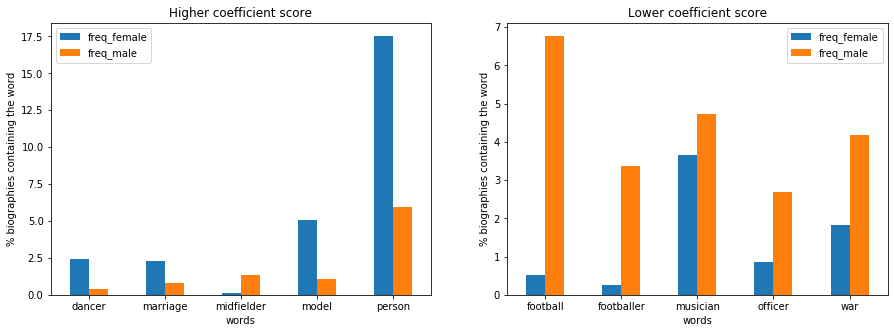

In [98]:
num_words = 5

f, ax = plt.subplots(1, 2, figsize=(15,5))
words_presence[words_presence.words.isin(df_coef_adj_nouns.head(num_words)['word'].tolist())][['words', 'freq_female', 'freq_male']].\
plot(kind='bar', x='words', ax=ax[0], rot=0)
words_presence[words_presence.words.isin(df_coef_adj_nouns.tail(num_words)['word'].tolist())][['words', 'freq_female', 'freq_male']].\
plot(kind='bar', x='words', ax=ax[1], rot=0)

ax[0].set_title('Higher coefficient score')
ax[1].set_title('Lower coefficient score')
ax[0].set_ylabel('% biographies containing the word')
ax[1].set_ylabel('% biographies containing the word')
plt.show()

#### Joint appearance of nouns and adjectives

As stated before and as we could expect, there are some words that are highly correlated: football, footballer and midfielder. The correlation between football and midfielder as well as the one between football and footballer is higher in female descriptions than in male ones. The correlation between midfielder and footballer is higher for male descriptions than female ones. ThE combination of these words influence in determining if an overview is from a female or a male. Nevertheless, the correlation in all cases is lower than 0.3, so we still consider the coefficients as an indicative to reflect the importance of the model's features.

In [99]:
num_words = 5
fem_sim, male_sim = similarity_score(df_encoded_adj_noun_fem_pd, df_encoded_adj_noun_male_pd, \
                    df_coef_adj_nouns.head(num_words)['word'].tolist() + df_coef_adj_nouns.tail(num_words)['word'].tolist(), 'words')

 Processing 10 out of 10

In [100]:
words = df_coef_adj_nouns.head(num_adj)['word'].tolist() + df_coef_adj_nouns.tail(num_adj)['word'].tolist()

f_sim = np.zeros((len(words),len(words)))
m_sim = np.zeros((len(words),len(words)))

for i in range(len(words)):
    for j in range(i+1, len(words)):
        f_sim[i,j] = fem_sim[(words[i], words[j])]
        f_sim[j,i] = f_sim[i,j]
        m_sim[i,j] = male_sim[(words[i], words[j])]
        m_sim[j,i] = m_sim[i,j]

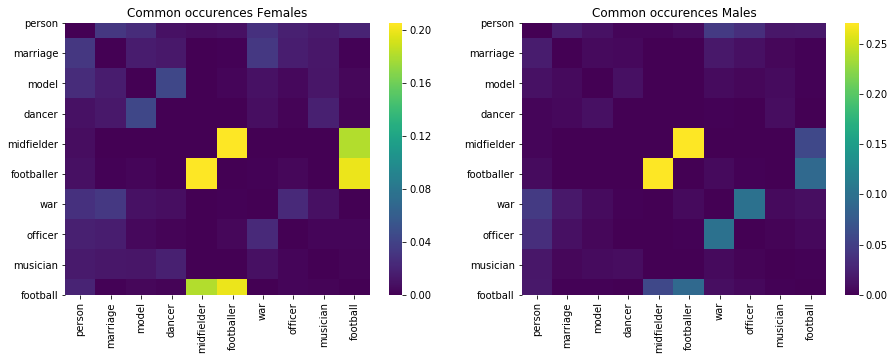

In [101]:
f, ax = plt.subplots(1,2, figsize=(15,5))
sns.heatmap(f_sim, xticklabels=words, yticklabels=words, cmap='viridis', ax=ax[0])
sns.heatmap(m_sim, xticklabels=words, yticklabels=words, cmap='viridis', ax=ax[1])

ax[0].set_title('Common occurences Females')
ax[1].set_title('Common occurences Males')

plt.show()

## Analyzing the results using the Empath library

Once we know the adjectives and nouns most predictive for male and females, we analyze them using Empath, a tool for analyzing text across lexical categories [[7]](https://hci.stanford.edu/publications/2016/ethan/empath-chi-2016.pdf). Using this library, we can get the categories associated to the results predicted from the model. We get the categories for the results using the model with only adjectives and the ones using both nouns and adjectives.

The results with only adjectives are very significant (females are related to whealthy and males to heroic), but we can extract more information about the topics from the results of the model with nouns and adjectives. In this case, we can observe that **women** are related to **family** in first place, whereas **men** are mostly related to **business and sports**. From this we can conclude that the **stereotypes are present on how people is portrayed in Wikipedia**.

In [102]:
print("Top topics of the most female correlated adjectives:\n")

adj_fem = list(df_coef[df_coef['coefficient'] > 0]['adjective'].values)
print(analyze_tokens(adj_fem))

Top topics of the most female correlated adjectives:

[('wealthy', 0.125), ('dominant_heirarchical', 0.1), ('competing', 0.1), ('reading', 0.075), ('gain', 0.075), ('strength', 0.075), ('achievement', 0.075), ('royalty', 0.05), ('art', 0.05), ('business', 0.05)]


In [103]:
print("Top topics of the most female correlated nouns and adjectives:\n")

adj_noun_fem = list(df_coef_adj_nouns[df_coef_adj_nouns['coefficient'] > 0]['word'].values)
print(analyze_tokens(adj_noun_fem))

Top topics of the most female correlated nouns and adjectives:

[('family', 0.14), ('reading', 0.1), ('school', 0.08), ('college', 0.08), ('music', 0.08), ('children', 0.08), ('musical', 0.08), ('dance', 0.06), ('wedding', 0.06), ('government', 0.06)]


In [104]:
print("Top topics of the most male correlated adjectives:\n")

adj_male = list(df_coef[df_coef['coefficient'] < 0]['adjective'].values)
print(analyze_tokens(adj_male))

Top topics of the most male correlated adjectives:

[('heroic', 0.06756756756756757), ('leader', 0.04054054054054054), ('politics', 0.04054054054054054), ('shape_and_size', 0.04054054054054054), ('negative_emotion', 0.04054054054054054), ('dispute', 0.02702702702702703), ('wealthy', 0.02702702702702703), ('stealing', 0.02702702702702703), ('divine', 0.02702702702702703), ('superhero', 0.02702702702702703)]


In [105]:
print("Top topics of the male correlated nouns and adjectives:\n")

adj_noun_male = list(df_coef_adj_nouns[df_coef_adj_nouns['coefficient'] < 0]['word'].values)
print(analyze_tokens(adj_noun_male))

Top topics of the male correlated nouns and adjectives:

[('business', 0.12195121951219512), ('sports', 0.12195121951219512), ('music', 0.0975609756097561), ('musical', 0.0975609756097561), ('occupation', 0.08536585365853659), ('school', 0.08536585365853659), ('college', 0.08536585365853659), ('leader', 0.08536585365853659), ('work', 0.08536585365853659), ('reading', 0.07317073170731707)]


## Future work 

- Add more features such as the years people lived or the length of the biographies to the propensity score matching.
- Extend the work using the whole biography instead of taking only the overview.
- Explore the bias using other Parts of Speech like verbs.

🦄🦄🦄🦄